<h1>Introduction</h1>
<p style="text-align:justify">
    The aim is  to predict the target value of investment IDs using a set of unknown features. Even the target itself is not known. Stock prices are volatile and even considered random due to the number of factors that affect the price. For example, the decision of a large volume of traders to buy the stock will lead to the increase of the price. Even politics do influence the stock market. Thus, making a model that can nearly match the target is not something feasible. Hence, <b>the aim is to produce a model that can predict the target value as good as possible</b>.
</p>

<h1>Importing The Packages</h1>

In [1]:
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import boruta
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import multivariate_normal
from numpy.linalg import norm

<h1>Get The Data</h1>
<p style="text-align:justify">
    I am using the <a href="https://www.kaggle.com/datasets/robikscube/ubiquant-parquet"> data in parquet format</a> done by Rob Mulla. There is another dataset that I created. I took the competition data and modified the datatypes to fit the memory. The difference between my data and Rob Mulla and mine is that I added lags of the target to add features. Thus, for training example at time <i>t<sub>i</sub></i>, it would have <i>t<sub>i-1</sub>, t<sub>i-2</sub> ..., t<sub>i-10</sub></i> as features. These features did increase the performance of the model, but only because true labels were used. During submissions I do not have access to the true lag values, hence I used the predictions from the model as lags and it did not make a positive impact on the scoring function. The reason for not using the competition data is that it does not fit the RAM given in a notebook. Moreover, it needed a lot of time to read the CSV file. Thus, another data source, in a different format, was needed. Furthermore, even using a better data format, it was still difficult to design the code so that operations do fit the RAM. Thus, I think this is the core challenge during the competition.
</p>
<p style="text-align:justify">
    In the code below, additionally than loading the data, a couple of columns were dropped. The columns used were picked using a correlation matrix. After inspecting the matrix, there are two features that have high correlation with time_id. Thus, I assumed these features are dragging down the model and removed the features. The removal of these features did enhance the performance of the model. The features are 'f_272' and 'f_200'.
</p>

In [2]:
t0=time.time()

use_lags=False# Bool that specifies if im going to use lags or not.

if use_lags:
    # Read the data with the lags.
    train_df = pd.read_parquet('../input/ubiquant-feature-selection/train_df_lags.parquet')
else:
    # Read the data without the lags.
    train_df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

# Drop Columns f_272 and f_200.
train_df.drop(columns=['f_272','f_200'],inplace=True)

print('finished reading the data')

print(f'It took {time.time()-t0} seconds')

finished reading the data
It took 43.55014634132385 seconds


In [3]:
def correlation_by_time(prediction_ls,y_test):
    '''
    Compute the correlations between the predictions and the true labels.
    
    args:
        prediction_ls: List of predictions from the model.
        y_test: The respective true outputs of the model.
    
    Note:
    prediction_ls is a list
    '''
    linear_pred=[pred for pred, cat in prediction_ls]# Get the linear outputs of the model.
    cat_pred=[cat for pred, cat in prediction_ls]# Get the categorical outputs of the model.

    del prediction_ls# Delete unnecessary files for memory to save space

    #convert to numpy array and compute the mean
    linear_prediction=np.stack(linear_pred)
    linear_prediction=linear_prediction.mean(axis=0).ravel()
    
    #convert to numpy array, give it the category with highest probability
    cat_prediction=np.stack(cat_pred)
    cat_prediction=cat_prediction.mean(axis=0)
    cat_prediction=np.argmax(cat_prediction,axis=1)
    #get the mean and median according to the category
    predict_mean=np.array([category_stats[cat]['mean'] for cat in cat_prediction])
    predict_median=np.array([category_stats[cat]['median'] for cat in cat_prediction])

    #find the correlation between the predictions and the y_test
    linear_correlation=np.corrcoef(x=linear_prediction,y=y_test)[0][1]
    mean_correlation=np.corrcoef(x=predict_mean,y=y_test)[0][1]
    median_correlation=np.corrcoef(x=predict_median,y=y_test)[0][1]
    
    return linear_correlation, mean_correlation, median_correlation

<p>
    I wanted to make a model for each investment ID. But, How much time would it take to generate the models, test them and save them. Furthermore, what should be done for unknown IDs. additionally, do we do an auto-encoder for each investment ID too? Thus, making one model for all investment IDs seems more convenient. I got an idea from a notebook. It mapped each ID to a unique integer and use an embedding layer to map them to vectors. This is the notebook if you want to <a href="https://www.kaggle.com/code/diedioskuren/ubiquant-more-models-ensemble">check it out</a>.
</p>
<p>
    At the beginning, the embedding was being used with the neural network model. However, later the layer is used in the auto-encoder. Afterwards, the auto-encoder would denoise the inputs and the model would use the denoised input without getting the investment ID input.
</p>

In [4]:
all_investment_ids=train_df['investment_id'].unique()#Get the unique investment ID values
n_investment_ids=len(all_investment_ids)
#Get an integer lookup that takes investment IDs and gives back a unique integer.
#This layer serves as a mapping from integer IDs to integers raging from -1 to length of IDs
investment_id_lookup_layer = keras.layers.IntegerLookup(max_tokens=n_investment_ids)
with tf.device("gpu"):
    investment_id_lookup_layer.adapt(all_investment_ids)
    
print('finished adapting the investment layer')

2022-04-23 17:39:08.977412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:39:09.087400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:39:09.088237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:39:09.090879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

finished adapting the investment layer


In [5]:
MAX_TIME=train_df['time_id'].max()#Get the max time ID

<h1>Model</h1>
<p style="text-align:justify">
    Deep neural networks is used to model the data. Neural Networks are strong to even model random noise. This property makes them sensible to noisy data and prone to over-fitting. Yet, using dropout as well as denoising auto-encoders can reduce overfitting. The techniques used:
    <dl>
        <dt><b>Denoising auto-encoder</b></dt>
        <dd style="text-align:justify">- Using auto-encoders to denoise the inputs before feeding them to the model.</dd>
        <dt><b>Multitask Learning</b></dt>
        <dd style="text-align:justify">- Instead of just predicting the target value, the model can use other targets related to the task. In this way, the model may learn more usefull features for the original task.</dd>
        <dt><b>MC Dropout</b></dt>
        <dd style="text-align:justify">- Regular dropout only works during training. MC dropout is the same as regular dropout, but it is applied during testing too. During testing, instead of predicting once, the outcome can be predicted many times. All will be using different neurons to predict the output. The outputs values can be averaged to obtain the expectation of the output given the model weights. This technique is an approximation of bayesian neural networks.</dd>
        <dt><b>Intermediary Outputs</b></dt>
        <dd style="text-align:justify">- Intermediary outputs are outputs coming from hidden layers. For example, instead of using just the final output layer to predict the outcome, an output layer is attached to hidden layers too. This technique can help reduce over-fitting and reaching convergence faster.</dd>
        <dt><b>Skip Layers</b></dt>
        <dd style="text-align:justify">- Just like ResNet, skips can facilitate convergence to the model. ResNet sums the inputs with the output of the next layer. I found that it works better with concatenating the instead of summing.</dd>
    </dl>
</p>
<p>The implementations are given below:</p>

In [6]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        # Like I said, it is regular dropout but it is always in training mode even during testing.
        return super().call(inputs, training=True)

In [7]:
def neural_model(investment_id_size,
                    n_features,
                    skip=True,
                    ensemble=True,
                    neuron_list=[40,40,30,20],
                    activation='elu',
                    input_dropout=0.6,
                    layer_dropout=0.4,
                    reg_imp=0.001,
                    n_bins=0,
                    use_conv=True,
                    filters=64,
                    kernel_size=3,
                    pool_size=5,
                    strides=2):
    
    #Clear any previous model
    tf.keras.backend.clear_session()
    
    #Intermediary outputs
    output=[]
    cat_output=[]
    
    #Pick weight initializer according to the activation function selected
    if activation in ['elu','relu','LeakyRelu','swish']:
        weights_initializer=tf.keras.initializers.he_normal
    
    if activation in ['selu']:
        weights_initializer=tf.keras.initializers.lecun_normal
        
    if activation in ['tanh','sigmoid','softmax','linear']:
        weights_initializer=tf.keras.initializers.glorot_normal
    
    #create an input layer, normalize the input, and add dropout on the input
    feature_inputs=tf.keras.layers.Input(shape=(n_features),name='Input_Layer',dtype=tf.float32)
    
    #If investment ID embedding is wanted in the model, then investment_id_size will be greater than 0 else it will be 0 
    if investment_id_size>0:
        #Make the embedding layer
        investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
        investment_id_x = investment_id_lookup_layer(investment_id_inputs)
        investment_id_x = keras.layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
        
        #Reshape the embedding vector
        investment_id_x = keras.layers.Reshape((-1,))(investment_id_x)
        
        #concatenate the feature input with the embedding vector
        inputs=tf.keras.layers.concatenate([investment_id_x,feature_inputs])
    else:
        #Only use the feature vectors
        inputs=feature_inputs
        
    x=MCDropout(input_dropout,name='Dropout_input')(inputs)# Add Dropout
    x_prev=x #save the input
    
    i=1
    for units in neuron_list:
        
        x=tf.keras.layers.Dense(units=units,name='Layer_1_'+str(i),use_bias=True,kernel_initializer=weights_initializer)(x)#l2(reg_imp)
        
        x=MCDropout(layer_dropout,name='Dropout_1_'+str(i))(x)
        if activation=='LeakyRelu':
            x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        else:
            x=tf.keras.activations.get(activation)(x)
        if skip:
            x=tf.keras.layers.concatenate([x_prev,x])
            x=tf.keras.layers.Dense(units=units,name='Layer_2_'+str(i),use_bias=True,kernel_initializer=weights_initializer)(x)#kernel_regularizer=l2(reg_imp)
            
            x=MCDropout(layer_dropout,name='Dropout_2_'+str(i))(x)
            if activation=='LeakyRelu':
                x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
            else:
                x=tf.keras.activations.get(activation)(x)
        
        if ensemble:
            output.append(tf.keras.layers.Dense(units=1,use_bias=True)(x))
            if n_bins>0:
                cat_output.append(tf.keras.layers.Dense(units=n_bins,activation='tanh',use_bias=True)(x))
        
        if use_conv:
            x=tf.expand_dims(x, -1)
            x=tf.keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,padding='same')(x)

            if activation=='LeakyRelu':
                x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
            else:
                x=tf.keras.activations.get(activation)(x)

            x=tf.keras.layers.MaxPool1D(pool_size=pool_size,strides=strides)(x)

            x=tf.keras.layers.Flatten()(x)
        
        x_prev=x
        
        i+=1
    
    #If multi-output, then concatenate the outputs of each layer
    if ensemble:
        x=tf.keras.layers.concatenate(output)
    #get the activation layer
    output_activation=tf.keras.activations.tanh
    
    y=tf.keras.layers.Dense(units=1,use_bias=True,name='linear_output')(x)
        
    if n_bins>0:
        if ensemble:
            x_cat=tf.keras.layers.concatenate(output)
        else:
            x_cat=x
            
        y_categorical=tf.keras.layers.Dense(n_bins, activation='softmax',name='categorical_output')(x_cat)
        
        y=[y,y_categorical]
    
    if investment_id_size>0:
        x_input=[investment_id_inputs,feature_inputs]
    else:
        x_input=feature_inputs
    
    mod=tf.keras.Model(inputs=x_input,outputs=y)
    
    
    return mod


In [8]:
def neural_model_2(investment_id_size,
                n_features,
                skip=True,
                ensemble=True,
                neuron_list=[40,40,30,20],
                activation='elu',
                input_dropout=0.6,
                layer_dropout=0.4,
                reg_imp=0.001,
                n_bins=0):
    
    #Clear any previous model
    tf.keras.backend.clear_session()
    
    output=[]
    cat_output=[]
    
    #Pick weight initializer according to the activation function selected
    if activation in ['elu','relu','LeakyRelu']:
        weights_initializer=tf.keras.initializers.he_normal
    
    if activation in ['selu']:
        weights_initializer=tf.keras.initializers.lecun_normal
        
    if activation in ['tanh','sigmoid','softmax','linear']:
        weights_initializer=tf.keras.initializers.glorot_normal
    
    #create an input layer, normalize the input, and add dropout on the input
    if type(n_features) is int:
        feature_inputs=tf.keras.layers.Input(shape=(n_features),name='Input_Layer')
    else:
        feature_inputs=n_features
        
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = keras.layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    
    investment_id_x = keras.layers.Reshape((-1,))(investment_id_x)
    
    inputs=tf.keras.layers.concatenate([investment_id_x,feature_inputs])
    
    x=tf.keras.layers.BatchNormalization()(inputs)
    x=MCDropout(input_dropout,name='Dropout_input')(x)
    x_prev=x #save the input
    
    i=1
    for units in neuron_list:
        
        x=tf.keras.layers.Dense(units=units,name='Layer_1_'+str(i),use_bias=True,kernel_initializer=weights_initializer)(x)
        x=MCDropout(layer_dropout,name='Dropout_1_'+str(i))(x)
        if activation=='LeakyRelu':
            x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        else:
            x=tf.keras.activations.get(activation)(x)
        if skip:
            x_skip=tf.keras.layers.Dense(units=units,name='Layer_2_'+str(i),use_bias=True,kernel_initializer=weights_initializer)(x_prev)#kernel_regularizer=l2(reg_imp)
            
            x=MCDropout(layer_dropout,name='Dropout_2_'+str(i))(x_skip)
            if activation=='LeakyRelu':
                x_skip=tf.keras.layers.LeakyReLU(alpha=0.1)(x_skip)
            else:
                x_skip=tf.keras.activations.get(activation)(x_skip)
            
            x=tf.keras.layers.Add()([x,x_skip])
        if ensemble:
            output.append(tf.keras.layers.Dense(units=1,use_bias=True)(x))
            if n_bins>0:
                cat_output.append(tf.keras.layers.Dense(units=n_bins,activation='tanh',use_bias=True)(x))
                
        x_prev=x
        
        i+=1
        
    #If multi-output, then concatenate the outputs of each layer
    if ensemble:
        x=tf.keras.layers.concatenate(output)
        
    #Pass it to get the output
    y=tf.keras.layers.Dense(units=1,use_bias=True,name='linear_output')(x)
    
    y=y
    
    if n_bins>0:
        if ensemble:
            x_cat=tf.keras.layers.concatenate(output)
        else:
            x_cat=x
        y_categorical=tf.keras.layers.Dense(n_bins, activation='softmax',name='categorical_output')(x_cat)
        y=[y,y_categorical]
    
    #Generate the keras model using all the outputs.
    output.append(y)
    mod=tf.keras.Model(inputs=[investment_id_inputs,feature_inputs],outputs=y)

    return mod

In [9]:
def get_autoencoder(n_features,investment_id_size,encoding_len=100,is_sparse=False,activation='elu'):
    
    feature_inputs=tf.keras.layers.Input(shape=(n_features),name='Input_Layer')
        
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = keras.layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    
    investment_id_x = keras.layers.Reshape((-1,))(investment_id_x)
    
    inputs=tf.keras.layers.concatenate([investment_id_x,feature_inputs])
    
    y=keras.layers.Dropout(0.5)(inputs)
    y=keras.layers.Dense(100, activation=activation)(y)
    y=keras.layers.Dense(encoding_len)(y)
    
    if is_sparse:
        y=tf.keras.activations.get('sigmoid')(y)
        y=tf.keras.layers.ActivityRegularization(l1=1e-3)(y)
    
    dropout_encoder=keras.Model(inputs=[investment_id_inputs,feature_inputs],outputs=y)
    
    dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation=activation, input_shape=[encoding_len]),
    keras.layers.Dense(len(features))
    ])
    outputs = dropout_decoder(dropout_encoder.output)
    
    autoencoder=keras.Model(inputs=[investment_id_inputs,feature_inputs],outputs=outputs)
    
    return autoencoder,dropout_encoder

<p style="text-align:justify">
    For feature selection, at the beggining I tried boruta and RFE to select features. Sadly, It took too much time and there was not much improvement on some small tests. Moreover, I have tried them on US market before and they did not give me good results at that time. Thus, I decided to stop it and try to do it manually or using auto-encoders. Hence, I generated a correlation file containing the correlations between the columns and tried to hand pick columns. As stated before, I found two columns significantly correlated to time and removing them boosted the performance of the model(score increased around 0.08-0.09 which is quite a lot in this competitions giving the top scores). I tried picking features by hand; but, it went down. Giving the small amount of time left, I decided to try denoising and sparse auto-encoders.
</p>

In [10]:
investments_data=list(train_df['investment_id'].unique())
investment_count=len(investments_data)

if use_lags:
    features=train_df.columns[train_df.columns.map(lambda x:'f' in x or 'lag' in x)]
else:
    features=train_df.columns[train_df.columns.map(lambda x:'f' in x)]

manual=False
if manual:
    features=[f'f_{int(i)}' for i in [0,5,6,7,182,183,196,201,224,227,231,258,266,281,283,284,293,296,298,294,291,204,
                                        241,209,12,13,20,27,34,37,44,66,74,99,108,122,124,127,154,166,170,175,177,249,
                                        249,225,176,153,126,102,56,63,19,53,244,239,236,299]]

print('features are:\n',features)

number_features=len(features)

feature_selection=False

features are:
 Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=298)


In [11]:
use_autoencoder=True
denoising=True
encoding_len=90
is_sparse=False
activation='elu'

remove_outliers=False
lower_percentile=30
upper_percentile=70

add_feature_errors=False

autoencoder_epochs=16

dropout_ae,encoder=get_autoencoder(number_features,investment_id_size=n_investment_ids,encoding_len=encoding_len,activation=activation,is_sparse=is_sparse)

if add_feature_errors:
    number_features=number_features*2

autoencoder_callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='loss',
                        min_delta=0.001,
                        patience=2,
                        verbose=1,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=False,
                    )]

In [12]:
NUMBER_SAMPLES=100

<h1>
    Testing
</h1>
<p>
    A rolling window approach was used to test the model. During each window, the model of the previous window is being re-trained on the current data. The current data is a mix of data from the previous window and new data.
</p>

In [13]:
test=True

skip=True
ensemble=True
neuron_list=[80,40,30,30,20]
activation='swish'
input_dropout=0.3
layer_dropout=0.5#0.4
reg_imp=0.001
n_bins=20
use_conv=True
filters=128
kernel_size=5
pool_size=5
strides=2

epochs=40
batch_size=128
shuffle=False
verbose=0

# Set early stopping to be used by the model

callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.2,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)]

window=140

step=60
n_rounds=3

valuation_window=40

if use_autoencoder:
    n_investment_ids=0
    if not denoising:
        number_features=encoding_len

print(number_features)
print('Before Model  fine')
# Generate the model
model=neural_model(investment_id_size=n_investment_ids,
                    n_features=number_features,
                    skip=skip,
                    ensemble=ensemble,
                    neuron_list=neuron_list,
                    activation=activation,
                    input_dropout=input_dropout,
                    layer_dropout=layer_dropout,
                    reg_imp=reg_imp,
                    n_bins=n_bins,
                    use_conv=use_conv,
                    filters=filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    strides=strides)

if n_bins>0:
    loss=[tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.CategoricalCrossentropy()]#Huber(delta=2)
    loss_weights=[0.8,0.2]
    model.compile(optimizer='adam',loss=loss,loss_weights=loss_weights)
else:
    model.compile(optimizer='adam',loss=tf.keras.losses.MeanAbsoluteError())

print('After Model fine')

use_categorical=True
use_mean=True
if n_bins>0:
    cuts,bins=pd.qcut(train_df['target'],n_bins,labels=[i for i in range(n_bins)],retbins=True)
    cat_target_column='cat target'
    train_df[cat_target_column]=cuts.astype(np.int8).copy()
    
    category_stats={}
    for cat_target, group in train_df.groupby(cat_target_column):
        category_stats[cat_target]={}
        category_stats[cat_target]['mean']=group["target"].mean()
        category_stats[cat_target]['median']=group["target"].median()
        category_stats[cat_target]['std']=group["target"].std()
        
        del group
    
    del cuts
    del bins

linear_results={}
metric_result={}
i=0
if test:
    for i in range(n_rounds-1,-1,-1):
        print(f'iteration {i} started fine')
        # Calculate the time interval to filter the data according to time
        end_time=MAX_TIME-valuation_window-step*i
        start_time=end_time-window

        #get the Data
        X_train_df=train_df[(train_df['time_id']>=start_time) & (train_df['time_id']<=end_time)].fillna(0)
        X_test_df=train_df[(train_df['time_id'] > end_time) & (train_df['time_id'] <= end_time+valuation_window)].fillna(0)
            
        y_train=X_train_df['target'].values
        y_train_cat=X_train_df[cat_target_column].values
        investment_ids_values_train=X_train_df['investment_id'].values.reshape(-1,1)
        
        print(features)
        X_train=X_train_df[features].values

        y_test=X_test_df['target'].values
        investment_ids_values_test=X_test_df['investment_id'].values.reshape(-1,1)
        X_test=X_test_df[features].values

        
        
        if use_autoencoder:
            print('auto-encoder')
            dropout_ae.compile(loss="mae",optimizer=keras.optimizers.Adam())
            dropout_ae.fit([investment_ids_values_train,X_train], X_train, epochs=autoencoder_epochs, verbose=verbose,callbacks=autoencoder_callbacks)
            print('finished auto-encoder')
            if remove_outliers:
                error=np.sum(X_train-dropout_ae.predict([investment_ids_values_train,X_train]),axis=1)
                lower_value,upper_value=np.percentile(error,[lower_percentile,upper_percentile])
                non_outliers_bool=np.logical_and(error>lower_value, error<upper_value)
                X_train=X_train[non_outliers_bool,:]
                investment_ids_values_train=investment_ids_values_train[non_outliers_bool]
                y_train=y_train[non_outliers_bool]
                y_train_cat=y_train_cat[non_outliers_bool]
                
                print('X_train.shape: ',X_train.shape)
                print('investment_ids_values_train.shape: ',investment_ids_values_train.shape)
                print('y_train.shape: ',y_train.shape)
                print('y_train_cat.shape: ',y_train_cat.shape)
                
            if denoising:
                print('Denoising')
                X_predicted=dropout_ae.predict([investment_ids_values_train,X_train])
                if add_feature_errors:
                    print('X_predicted.shape: ',X_predicted.shape)
                    error=np.sum(np.square(X_train-X_predicted),axis=1)
                    print('error.shape: ',error.shape)
                    X_train=np.concatenate((X_predicted,error),axis=1)
                    print('X_train.shape: ',X_train.shape)
                else:
                    X_train=X_predicted
            else:
                X_train=encoder.predict([investment_ids_values_train,X_train])
            print(f'X_train Shape: {X_train.shape}')
            
        else:
            print(f'training on: {len(X_train)}')
            X_train=[investment_ids_values_train,X_train]
        
        if n_bins>0:
            y_train=[y_train, tf.one_hot(y_train_cat,depth=n_bins,dtype=tf.int8)]
            y_test=[y_test, tf.one_hot(X_test_df[cat_target_column],depth=n_bins,dtype=tf.int8)]
            
        # Train the model
        print(f'Started Training for iteration {n_rounds-i}')
        model.fit(X_train,y_train,batch_size=batch_size,shuffle=shuffle,epochs=epochs,verbose=verbose,callbacks=callbacks)
        print(f'Finished Training for iteration {n_rounds-i}')
        
        del X_train
        del y_train
        
        linear_results[f'iteration {n_rounds-i}']={}
        metric=[]
        mean_metric=[]
        median_metric=[]
        print(f'valuating on {len(X_test_df)} samples')
        for time, test_group in X_test_df.groupby('time_id'):
        
            y_test=test_group['target'].values
            investment_ids_values_test=test_group['investment_id'].values.reshape(-1,1)
            X_test=test_group[features].values
            
            if use_autoencoder:
                print('convert data using auto-encoder')
                if denoising:
                    X_test_predicted=dropout_ae.predict([investment_ids_values_test,X_test])
                    if add_feature_errors:
                        error=np.sum(np.square(X_test-X_test_predicted),axis=1)
                        X_test=np.concatenate((X_test_predicted,error),axis=1)
                    else:
                        X_test=X_test_predicted
                else:
                    X_test=encoder.predict([investment_ids_values_test,X_test])
                
            else:
                X_test=[investment_ids_values_test,X_test]

            prediction_ls=[model.predict(X_test)for sample in range(NUMBER_SAMPLES)]

            if n_bins>0:
                linear_correlation, mean_correlation, median_correlation=correlation_by_time(prediction_ls,y_test)
                
                mean_metric.append(mean_correlation)
                median_metric.append(median_correlation)
            else:
                y_probas = np.stack(prediction_ls)
                y_proba = y_probas.mean(axis=0)
                predictions=y_proba.ravel()

                linear_correlation=np.corrcoef(x=predictions,y=y_test)[0][1]
                
            metric.append(linear_correlation)
            
            del test_group

        if n_bins>0:
            print('score using mean of cat: ',np.mean(mean_metric))
            print('score using median of cat: ',np.mean(median_metric))
        
        print('score using linear output: ',np.mean(metric))
        
        


298
Before Model  fine
After Model fine
iteration 2 started fine
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=298)
auto-encoder


2022-04-23 17:39:21.390331: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 522392808 exceeds 10% of free system memory.
2022-04-23 17:39:22.248458: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 522392808 exceeds 10% of free system memory.
2022-04-23 17:39:22.775777: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 522392808 exceeds 10% of free system memory.
2022-04-23 17:39:23.144890: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 522392808 exceeds 10% of free system memory.


Epoch 00008: early stopping
finished auto-encoder
Denoising


2022-04-23 17:43:40.760980: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 522392808 exceeds 10% of free system memory.


X_train Shape: (438249, 298)
Started Training for iteration 1


2022-04-23 17:44:05.650242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch 00004: early stopping
Finished Training for iteration 1
valuating on 125276 samples
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data using auto-encoder
convert data u

<h1>Final Model</h1>
<p>
    In this last step the model is re-trained on the latest data. Thus, the model will would have trained on the latest data. Although, to be realistic, the data used for testing will have a different distribution from training. The reason is the time difference between training and testing data (and stock trading is a time variant task). Thus, models will not be so performant and I think the public leaderboard is proving that.
</p>

In [14]:
# Train on the latest data before saving the model
end_time=MAX_TIME
start_time=end_time-window

#get the Data
X_train_df=train_df[(train_df['time_id']>=start_time) & (train_df['time_id']<=end_time)].fillna(0)

del train_df

X_train_df=X_train_df.sort_values(['investment_id','time_id'])

y_train=X_train_df['target'].values
y_train_cat=X_train_df[cat_target_column]
investment_ids_values_train=X_train_df['investment_id'].values.reshape(-1,1)
X_train=X_train_df[features].values
    
if use_autoencoder:
    print('auto-encoder')
    dropout_ae.compile(loss="mae",optimizer=keras.optimizers.Adam())
    dropout_ae.fit([investment_ids_values_train,X_train], X_train, epochs=autoencoder_epochs,verbose=verbose,callbacks=autoencoder_callbacks)
    print('finished auto-encoder')
    if remove_outliers:
        error=np.sum(X_train-dropout_ae.predict([investment_ids_values_train,X_train]),axis=1)
        lower_value,upper_value=np.percentile(error,[lower_percentile,upper_percentile])
        non_outliers_bool=np.logical_and(error>lower_value, error<upper_value)
        X_train=X_train[non_outliers_bool,:]
        investment_ids_values_train=investment_ids_values_train[non_outliers_bool]
        y_train=y_train[non_outliers_bool]
        y_train_cat=y_train_cat[non_outliers_bool]
        
    if denoising:
        print('Denoising')
        X_predicted=dropout_ae.predict([investment_ids_values_train,X_train])
        if add_feature_errors:
            print('X_predicted.shape: ',X_predicted.shape)
            error=np.sum(np.square(X_train-X_predicted),axis=1)
            print('error.shape: ',error.shape)
            X_train=np.concatenate((X_predicted,error),axis=1)
            print('X_train.shape: ',X_train.shape)
        else:
            X_train=X_predicted
    else:
        X_train=encoder.predict([investment_ids_values_train,X_train])
    print(f'X_train Shape: {X_train.shape}')
    encoder.save("encoder.tf",save_format='tf')
    dropout_ae.save("autoencoder.tf",save_format='tf')
    
else:
    print(f'training on: {len(X_train)}')
    X_train=[investment_ids_values_train,X_train]

#make categorical input
if n_bins>0:
    y_train=[y_train, tf.one_hot(y_train_cat,depth=n_bins,dtype=tf.int8)]

print('started training')
# Train the model
model.fit(X_train,y_train,batch_size=batch_size,shuffle=shuffle,epochs=40,verbose=verbose, callbacks=callbacks)
print('finished training')

model.save("my_model.tf",save_format='tf')

auto-encoder
Epoch 00003: early stopping
finished auto-encoder
Denoising
X_train Shape: (462700, 298)


2022-04-23 18:57:54.900473: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


started training
Epoch 00004: early stopping
finished training


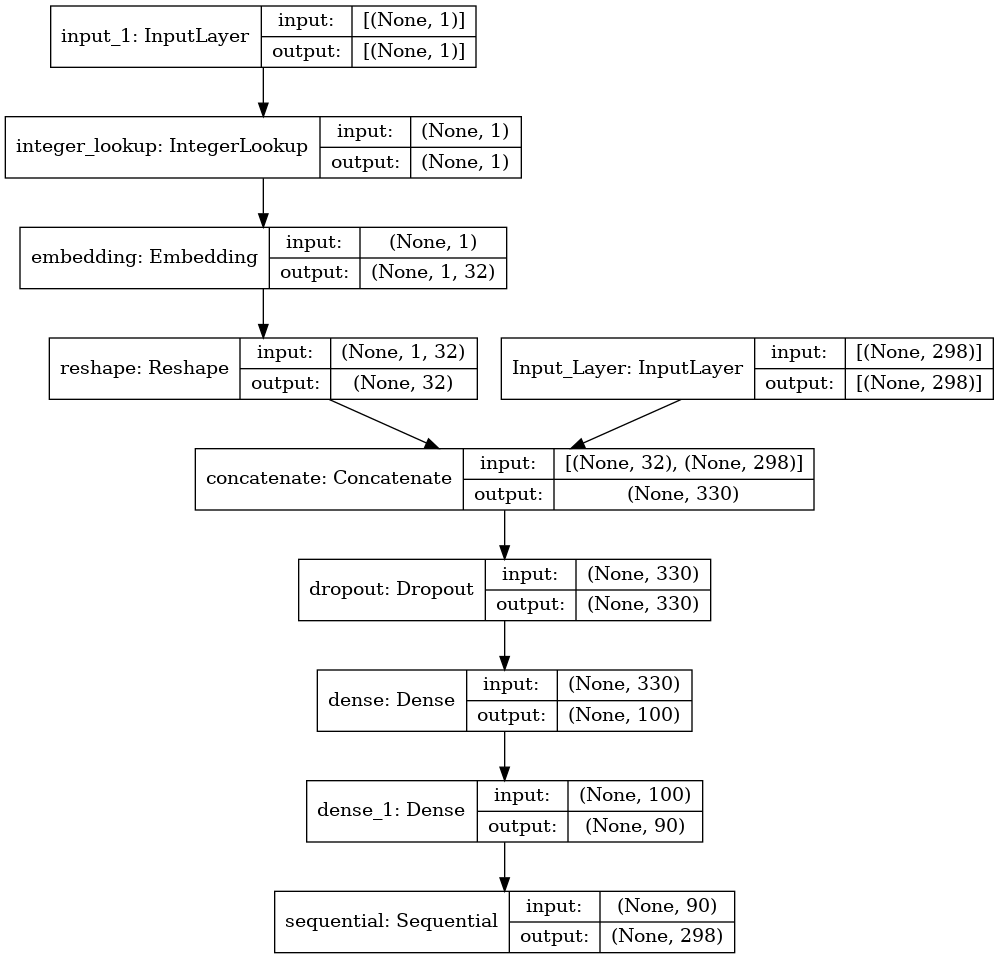

In [15]:
tf.keras.utils.plot_model(dropout_ae, to_file='auto-encoder.png', show_shapes=True)

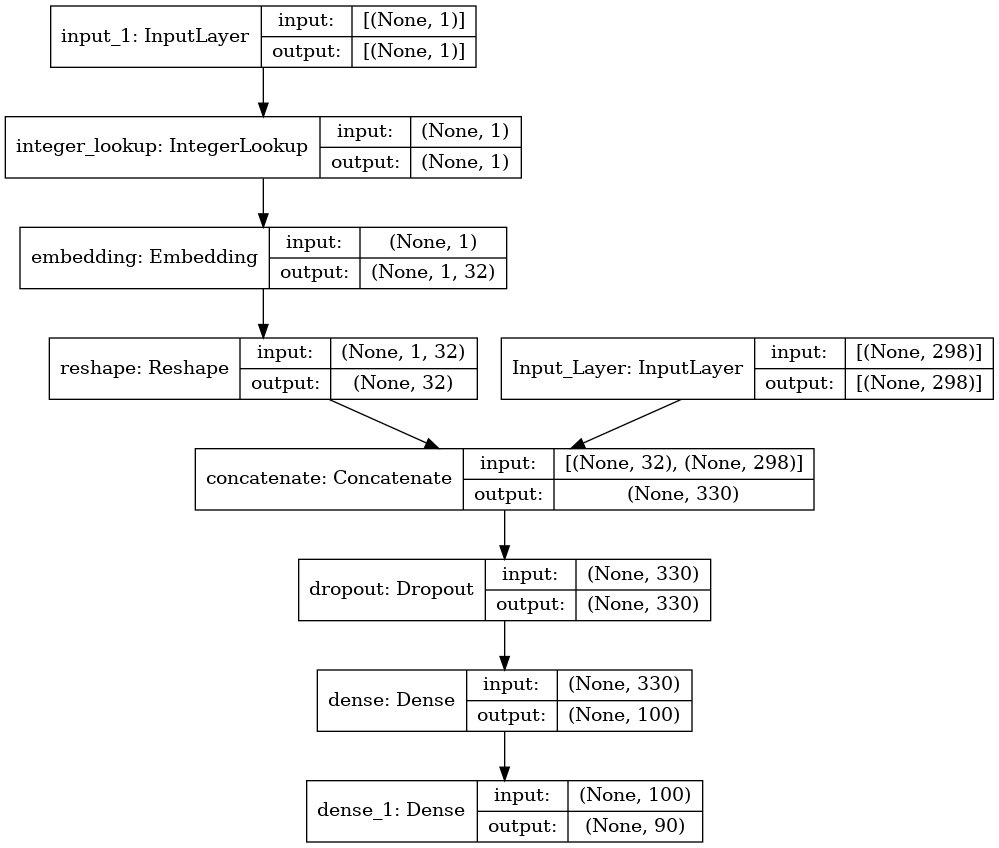

In [16]:
tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True)

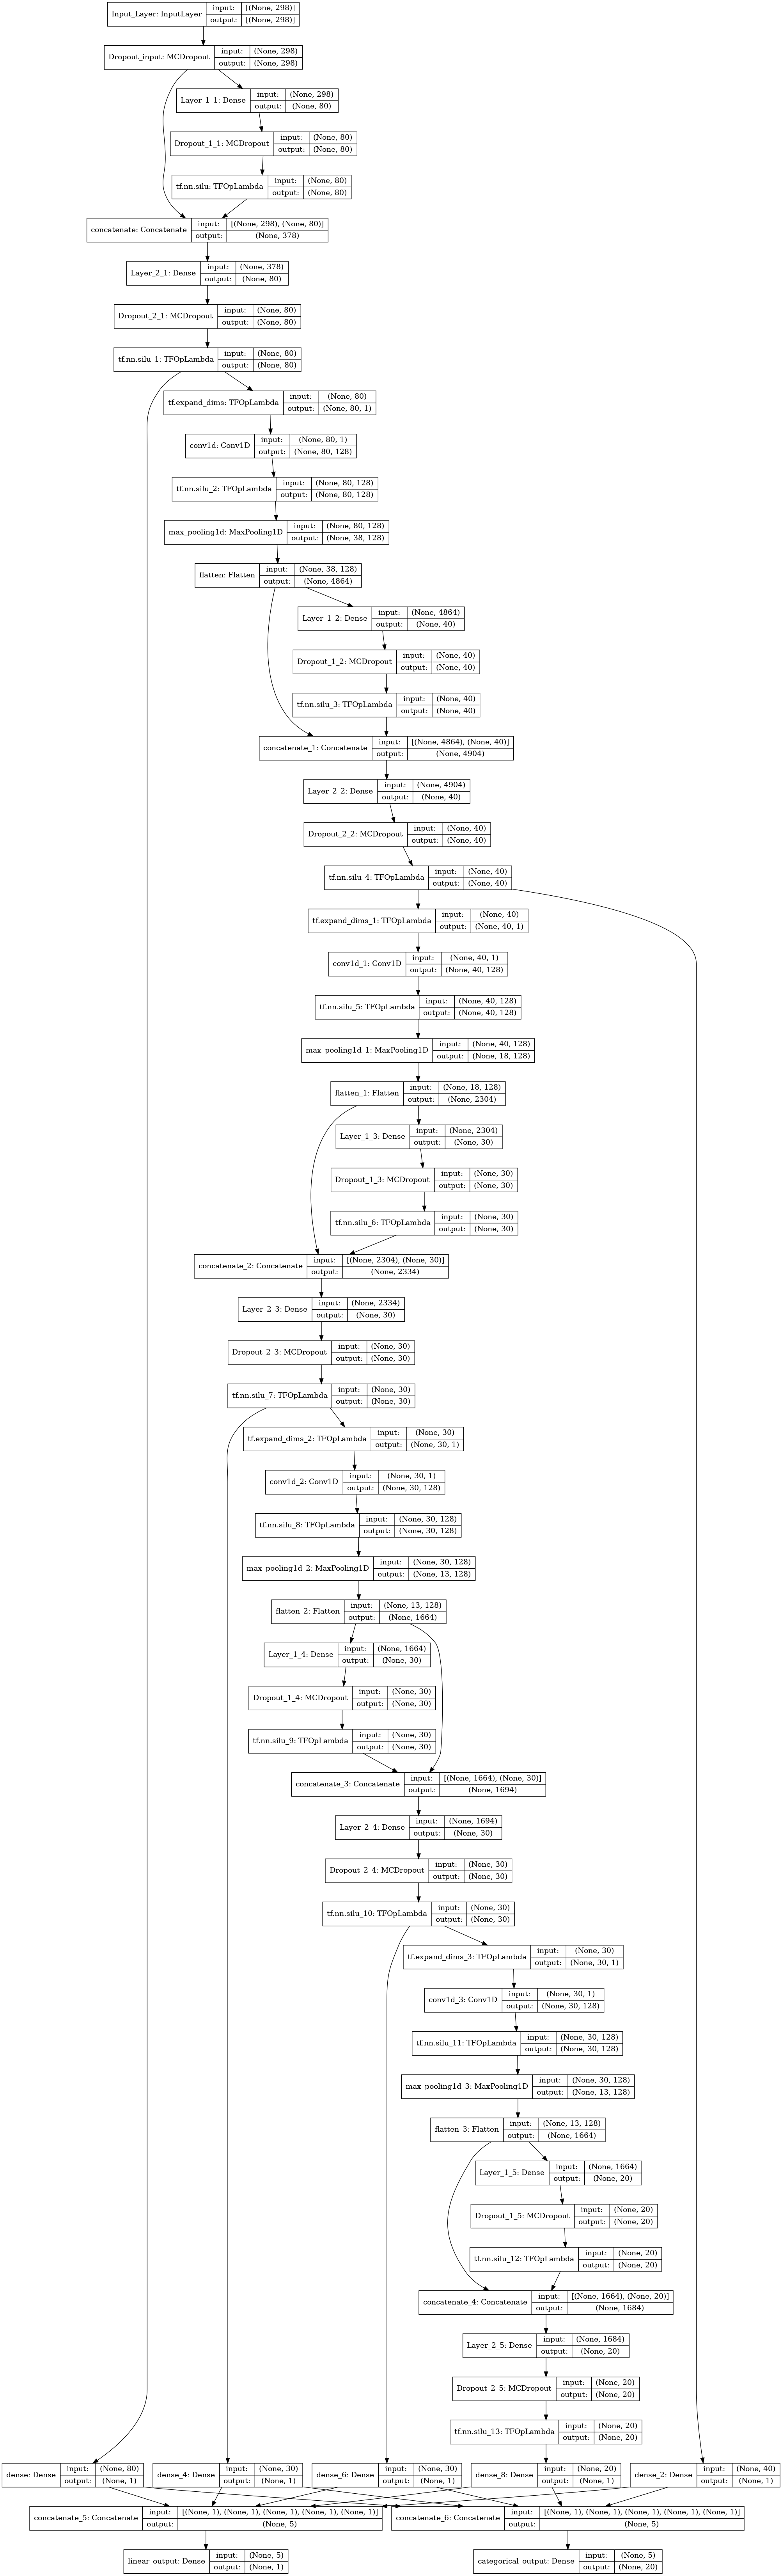

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

<h1>Conclusion</h1>

<p>
    As a conclusion, the best model went from 0.0376 to 0.1228 score. Among the techniques used, the feature selection significantly enchanced the model. The deletion of the two features 'f_272' and 'f_200' did enhance the performance by a significant margin. Hence, manipulating the features and denoising the data have a good chance of giving a better score. Moreover, even changing how to tackle the task may help too. As an example, dividing the data into types and for each type use a different model dedicated to that category. Or even decomposing the series into multiple series and have a different technique for each series.
</p>

<h1>Ending Thoughts</h1>

<p>
    This is my first serious competition. I found it beneficial the need to write code and modify data so that it feets the memory requirements. It feels it took me a level ahead. Moreover, I was amazed at the level of competition. I think everyone in the first 1000 places (at least) have a chance of winning. That shows that all the competitiors are amazing. Hopefully, next time I do better. I hope this notebook was helpfull.
</p>

<h1>
    Thank You for reading.
</h1>
